In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import random
random.seed(10)# fix randomness
import cupy as cp

Parameters for modeling

In [2]:
n = 512 # object size (nxn), detector size (nxn)
z = np.array([4.5e-3, 4.7e-3, 5e-3]) # positions of the sample wrt the focal spot [m]
voxelsize = 1e-8*2048/n # voxel size for computing propagation, 10nm corresponds to the detector 2048x2048 [m]
wavelength = 1.24e-09/33.35  # wave length for 33.35 keV energy [m]

npad = n//8 # padding of the object
ne = n+2*npad # size after padding

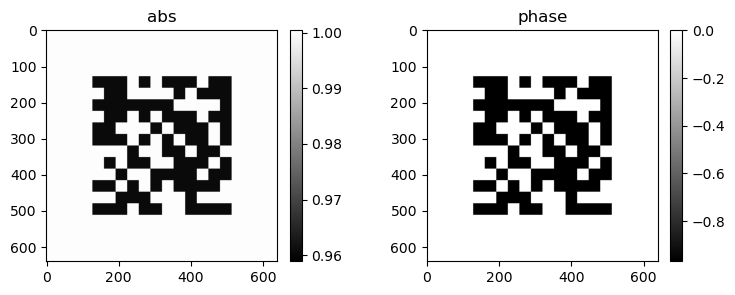

In [3]:
# generate 64x64 binary matrix
nill = 16
ill = np.zeros([nill*nill],dtype='bool')
ill_ids = random.sample(range(0, nill*nill), int(nill*nill*0.55))
ill[ill_ids] = 1
ill = ill.reshape(nill,nill)
# scale to the size nxn
ill = ndimage.zoom(ill,[n/nill,n/nill],order=0,grid_mode=True,mode='grid-wrap').astype('float64')

# ill+=(ill[::-1]+ill[:,::-1])/2

# make the transmittance function
beta = 1.1906916589949026e-07 # for gold
delta = 2.863698115973534e-06 # for gold
thickness = 2e-6/voxelsize # thickness of the object in pixels
Rill = ill*(-delta+1j*beta)*thickness

# make sure we have 0 on borders,
# work with padded version
Rill = np.pad(Rill[n//8:-n//8,n//8:-n//8],((npad+n//8,npad+n//8),(npad+n//8,npad+n//8)))

x = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex128')


# slightly smooth borders to avoid high frequency problems
v = np.arange(-ne//2,ne//2)/2/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-0.2*(vx**2+vy**2))
x = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(x)))
x = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(x*v))).astype('complex128')


# plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].imshow(np.abs(x), cmap='gray')
axs[0].set_title('abs')
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(np.angle(x), cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

16 8


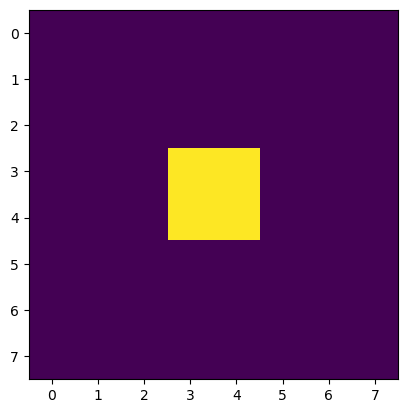

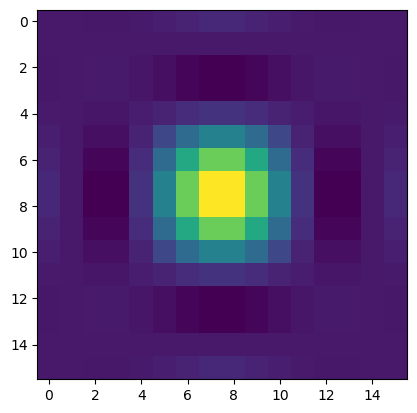

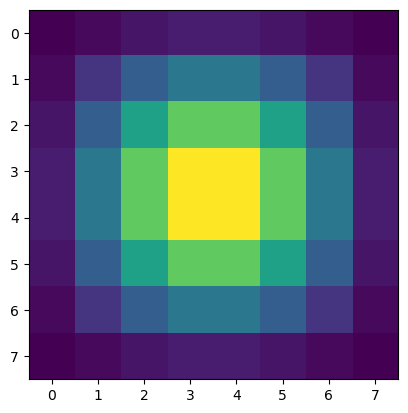

In [ ]:
from holotomocupy.magnification import M
from holotomocupy.utils import *
nn=8
xx = np.zeros([1,nn,nn]).astype('complex64')
xx[:,nn//2-nn//8:nn//2+nn//8,nn//2-nn//8:nn//2+nn//8]=1
magnification = 1.5
out_size = 2*nn
y = M(xx,magnification,out_size)

plt.imshow(xx[0].real)
plt.show()
plt.imshow(y[0].real)
plt.show()
plt.imshow(y[0,y.shape[1]//2-4:y.shape[1]//2+4,y.shape[1]//2-4:y.shape[1]//2+4].real)
plt.show()



Define the Fresnel transform operator and its adjoint

In [ ]:
def P(f, wavelength, voxelsize, z):
    """Fresnel transform

    Parameters
    ----------
    f : ndarray
        Input array to perform the Fresnel transform
    voxelsize : float
        Voxel size in m
    z : float
        Propagation distance in m

    Returns
    -------
    ff : ndarray
        Propagated function
    """

    fx = cp.fft.fftfreq(2*ne, d=voxelsize).astype('float64')
    [fx, fy] = np.meshgrid(fx, fx)

    fP = np.exp(-1j*np.pi*wavelength*z*(fx**2+fy**2))

    ff = np.pad(f,((ne//2,ne//2),(ne//2,ne//2)))
    ff = np.fft.ifft2(np.fft.fft2(ff)*fP)

    ff = ff[ne//2:-ne//2,ne//2:-ne//2]

    return ff*factor

factor =  100

def PT(f, wavelength, voxelsize, z):
    return P(f, wavelength, voxelsize, -z)


Make the joint operator L

In [ ]:
def L(f):
  res = cp.zeros([len(z),n,n],dtype='complex128')
  # f*=10
  for k in range(len(z)):
    res[k] = P(f,wavelength,voxelsize,z[k])[npad:-npad,npad:-npad]
  return res

def LT(d):
  res = cp.zeros([ne,ne],dtype='complex128')
  for k in range(len(z)):

    res += PT(np.pad(d[k],((npad,npad),(npad,npad))),wavelength,voxelsize,z[k])
  # res*=10
  return res

Generate data on the detector for $$d = \|L(x)\|^2$$

In [ ]:
x = cp.array(x)
data = (np.abs(L(x))**2)

# plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].imshow(data[0].get(), cmap='gray')
axs[0].set_title('data for the first distance')
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(data[-1].get(), cmap='gray')
axs[1].set_title('data for the last distance')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()


A method to find the initial guess

In [ ]:
def multiPaganin(data, distances, wavelength, voxelsize, delta_beta,  alpha):
    """ Phase retrieval based on the MultiPaganin method

    Parameters
    ----------
    data : ndarray, float32
        Input data for several distances, shape (ntheta,ndist,n,n)
    distance : ndarray
        Distances in m, shape (ndist)
    wavelength:
        Wave length in m
    voxelsize:
        Voxel size in m
    delta_beta:
        Ratio between the real and imag components of the refractive index (u=delta+ibeta)
    alpha:
        Constant to avoid division by zero

    Returns
    -------
    phase : ndarray
        Recovered phase of the object, shape [ntheta,n,n]
    """
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype('float64')
    [fx, fy] = np.meshgrid(fx, fx)

    numerator = 0
    denominator = 0
    for j in range(0, data.shape[0]):
        rad_freq = np.fft.fft2(data[j])
        taylorExp = 1 + wavelength * distances[j] * np.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2

    numerator = numerator / len(distances)
    denominator = (denominator / len(distances)) + alpha

    phase = np.log(np.real(np.fft.ifft2(numerator / denominator)))
    phase = (delta_beta) * 0.5 * phase

    return np.exp(1j*np.pad(phase,((npad,npad),(npad,npad))))

x_init = cp.array(multiPaganin(data/factor**2, z, wavelength, voxelsize, delta/beta,  1e-7))
# plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].imshow(np.abs(x_init).get(), cmap='gray')
axs[0].set_title('abs')
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(np.angle(x_init).get(), cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()


In [ ]:
niter = 1024

In [ ]:
# supplementary functions
def reprod(a,b):
    return a.real*b.real+a.imag*b.imag

a = 1+2*1j
b = 3-4*1j

print(reprod(a,b))

print(np.real(np.conj(a)*b))
print(np.real(np.conj(b)*a))




Make the conjugate gradient solver to solve $$\text{argmin}_x \||L(x)|-\sqrt{d}\|_2^2$$

In [ ]:
# def hessian2(Lx,Lgrad,Leta,data):
#     v1 = np.abs(Lx)-data
#     v2 = np.real(np.conj(Lgrad)*Leta)/np.abs(Lx)
#     v3 = np.real(np.conj(Lx)*Lgrad) * np.real(np.conj(Lx)*Leta) / np.abs(Lx)**3
#     return 2*(np.sum(v1 * np.conj(v2)) + np.sum(data*np.conj(v3)))

def hessian2(Lx,Lgrad,Leta,data):
    v1 = cp.real(cp.sum(Lgrad*cp.conj(Leta)))
    v2 = -np.sum(data*np.real(Lgrad*np.conj(Leta))/np.abs(Lx)**3)
    v3 = np.sum(data*np.real(np.conj(Lx)*Lgrad)*np.real(np.conj(Lx)*Leta)/np.abs(Lx)**4)
    # print(v1,v2,v3)
    return 2*(v1+v2+v3)

def cg_holo(data, x, niter):
    """Conjugate gradients method for holography"""
    import torch
    # minimization functional
    def minf(fx):
        # f = np.linalg.norm(fx)**2-np.sum(2*data*np.log(np.abs(fx)))
        loss = torch.nn.PoissonNLLLoss(log_input=False,reduction='mean',full=True)
        tfx = torch.from_numpy(fx.get())
        tdata = torch.from_numpy(data.get())        
        f = loss(torch.abs(tfx)**2,tdata)
        # f = np.linalg.norm(np.abs(fx)-data)**2
        return f

    # data = np.sqrt(data) # work with square root of data
    err = np.zeros(niter) # error array
    alpha = np.zeros(niter) # step array

    Lx = L(x)
    for i in range(niter):
        # gradient        
        # grad = 2*LT(Lx-data*np.exp(1j*np.angle(Lx)))
        grad = 2*LT(Lx-data*Lx/np.abs(Lx)**2)
        Lgrad = L(grad)

        # cg direction
        if i==0:
            eta = -grad
            Leta = -Lgrad
        else:
            beta = hessian2(Lx,Lgrad,Leta,data)/hessian2(Lx,Leta,Leta,data)
            eta = -grad + beta*eta
            Leta = -Lgrad + beta*Leta


        # step length
        alpha[i] =  -np.sum(np.real(grad*np.conj(eta)))/hessian2(Lx,Leta,Leta,data)
        # alpha[i] =0.01
        x += alpha[i]*eta
        Lx += alpha[i]*Leta

        # compute error
        err[i] = minf(Lx)#-ierr

        print(f'{i}) {alpha[i]=:1.3e}, {err[i]=:1.3e}')

    return x,err,alpha

# x_rec = cp.ones([ne,ne],dtype='complex64')
x_rec = cp.array(x_init.copy())
noise = (cp.random.random(x_init.shape)+1j*cp.random.random(x_init.shape))*0
x_rec+=noise
x_rec,err,alpha = cg_holo(data,x_rec,niter)

Results

In [ ]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].imshow(np.abs(x_rec).get(), cmap='gray')
axs[0].set_title('abs')
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(np.angle(x_rec).get(), cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].plot(err)
axs[0].set_title('error')
axs[0].set_xlabel('iter')
axs[0].set_yscale('log')
im = axs[1].plot(alpha)
axs[1].set_title('alpha')
axs[1].set_xlabel('iter')
im = axs[1].plot(alpha)
plt.show()



In [ ]:
def cg_holo(data, x, niter):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fx):
        f = np.linalg.norm(np.abs(fx)-data)**2
        return f

    data = np.sqrt(data) # work with square root of data

    err = np.zeros(niter) # error array
    alpha = np.zeros(niter) # step array

    Lx = L(x)
    for i in range(niter):
        # gradient
        grad = 2*LT(Lx-data*np.exp(1j*np.angle(Lx)))
        Lgrad = L(grad)

        # cg direction
        if i==0:
            eta = -grad
            Leta = -Lgrad
        else:
            beta = np.linalg.norm(grad)**2 / \
                    np.sum(np.real((np.conj(eta)*(grad-grad0))))
            eta = -grad + beta*eta
            Leta = -Lgrad + beta*Leta
        grad0 = grad


        # step length
        alpha[i] =  -np.sum(np.real(grad*np.conj(eta)))/hessian2(Lx,Leta,Leta,data)
        x += alpha[i]*eta
        Lx += alpha[i]*Leta

        # compute error
        err[i] = minf(Lx)

        print(f'{i}) {alpha[i]=:1.3e}, {err[i]=:1.3e}')

    return x,err,alpha

#x_rec = np.ones([ne,ne],dtype='complex64')
x_rec = cp.array(x_init.copy())
x_rec+=noise
x_rec1,err1,alpha1 = cg_holo(data,x_rec,niter)

In [ ]:
# plot
NN = niter
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].imshow(np.abs(x_rec1).get(), cmap='gray')
axs[0].set_title('abs')
fig.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(np.angle(x_rec1).get(), cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
im = axs[0].plot(err[:NN],label='5th')
im = axs[0].plot(err1[:NN],label='Dai')
axs[0].grid('on')
axs[0].legend()
axs[0].set_title('error')
axs[0].set_xlabel('iter')
axs[0].set_yscale('log')
im = axs[1].plot(alpha[:NN],label='5th')
im = axs[1].plot(alpha1[:NN],label='Dai')
axs[1].grid('on')
axs[1].legend()
axs[1].set_title('alpha')
axs[1].set_xlabel('iter')

plt.show()

